**PCS5024 - Aprendizado Estatístico**

**Name**: Rodrigo da Silva Cunha

**NUSP**: 7631302

# Building Classifiers for Adult Dataset

In this notebook we'll explore the Adult Dataset, available for download at the [UCI Repository](https://archive.ics.uci.edu/ml/datasets/adult), and build a few classifiers to predict the class variable ">50k", which defines if a person gets more than US\$50k/year or not. 

The work reported in this notebook is part of a practice assignment in the discipline PCS5024 - Aprendizado Estatístico. The complete code is avaialable at [GitHub](https://github.com/rodra-go/adult).

## 1. Loading Adult Dataset

The Adult dataset is composed of a three documents: 

- **adult.names**: contains general information about the dataset, such as column names, classification benchmarks, information about missing data and the dataset probability for the class labels.
- **adult.train**: random split containing 2/3 of the original dataset
- **adult.test**: random split containing 1/3 of the original dataset

Below we load the train and test datasets treating the '?' characters present in the dataset as missing data.

In [1]:
import pandas as pd

column_names = ['age','workclass','fnlwgt','education','education-num','marital-status',
                'occupation','relationship','race','sex','capital-gain','capital-loss',
                'hours-per-week','native-country','income']

train_data = pd.read_csv('../data/01_raw/adult.data', 
                         index_col = False,
                         na_values = ' ?',
                         names = column_names)
                         
test_data = pd.read_csv('../data/01_raw/adult.test', 
                         index_col = False,
                         na_values = ' ?',
                         names = column_names)

/home/user01/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2. Exploratory Data Analysis (EDA)

In this section we perform some analysis to better describe and understand the Adult dataset. In the following we describe the main aspectes of the Adult dataset highlighted in the EDA task. 

1. There is missing data present in the Adult dataset. The [**missingno**](https://pypi.org/project/missingno/) library can be used to plot the missing data in the dataset, what shows how the missing data is distributed. The plot highlights how the missing data is sparse and present on 3 features only. In fact, the rows with missing data correspond to 7.41% of the original dataset (3620 samples out of 48842).

In [2]:
# concatenating train and test datasets for analysis
eda_data = pd.concat([train_data,test_data])

missing_count = eda_data.shape[0] - eda_data.dropna().shape[0]
total_count = total_count = eda_data.shape[0]
print('Original dataset: {}'.format(str(total_count)))
print('Rows with missing data: {}'.format(str(missing_count)))
print('{:.2f}% of missing data.'.format(100*missing_count/total_count))

Original dataset: 48842
Rows with missing data: 3620
7.41% of missing data.


/home/user01/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

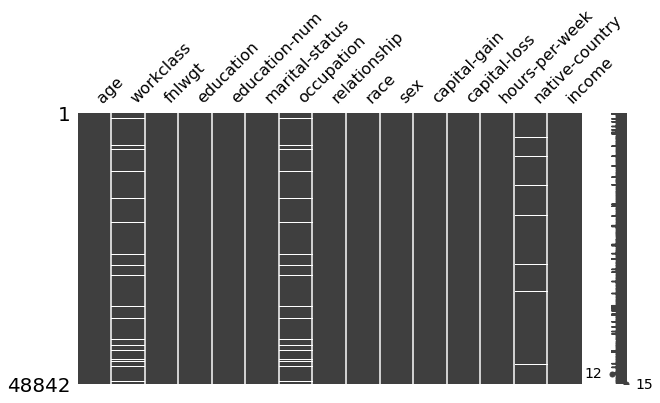

In [3]:
%matplotlib inline
import missingno as msn

msn.matrix(eda_data, figsize = (10,5))

Another aspect that can be pointed out is that only categorical features have missing data, therefore one approach to with it could be to set all of them as a new **UNKNOWN** category, in order to keep the data from the other features.

In [5]:
print('Columns with missing data: ', list(eda_data.columns[eda_data.isna().any()]))

Columns with missing data:  ['workclass', 'occupation', 'native-country']


2. **Categorical Features**: the plots bellow shows the categorial features present in the Adult dataset. Some of the features are not well balanced, with very few examples for some classes, such as in the **native-country** feature. 

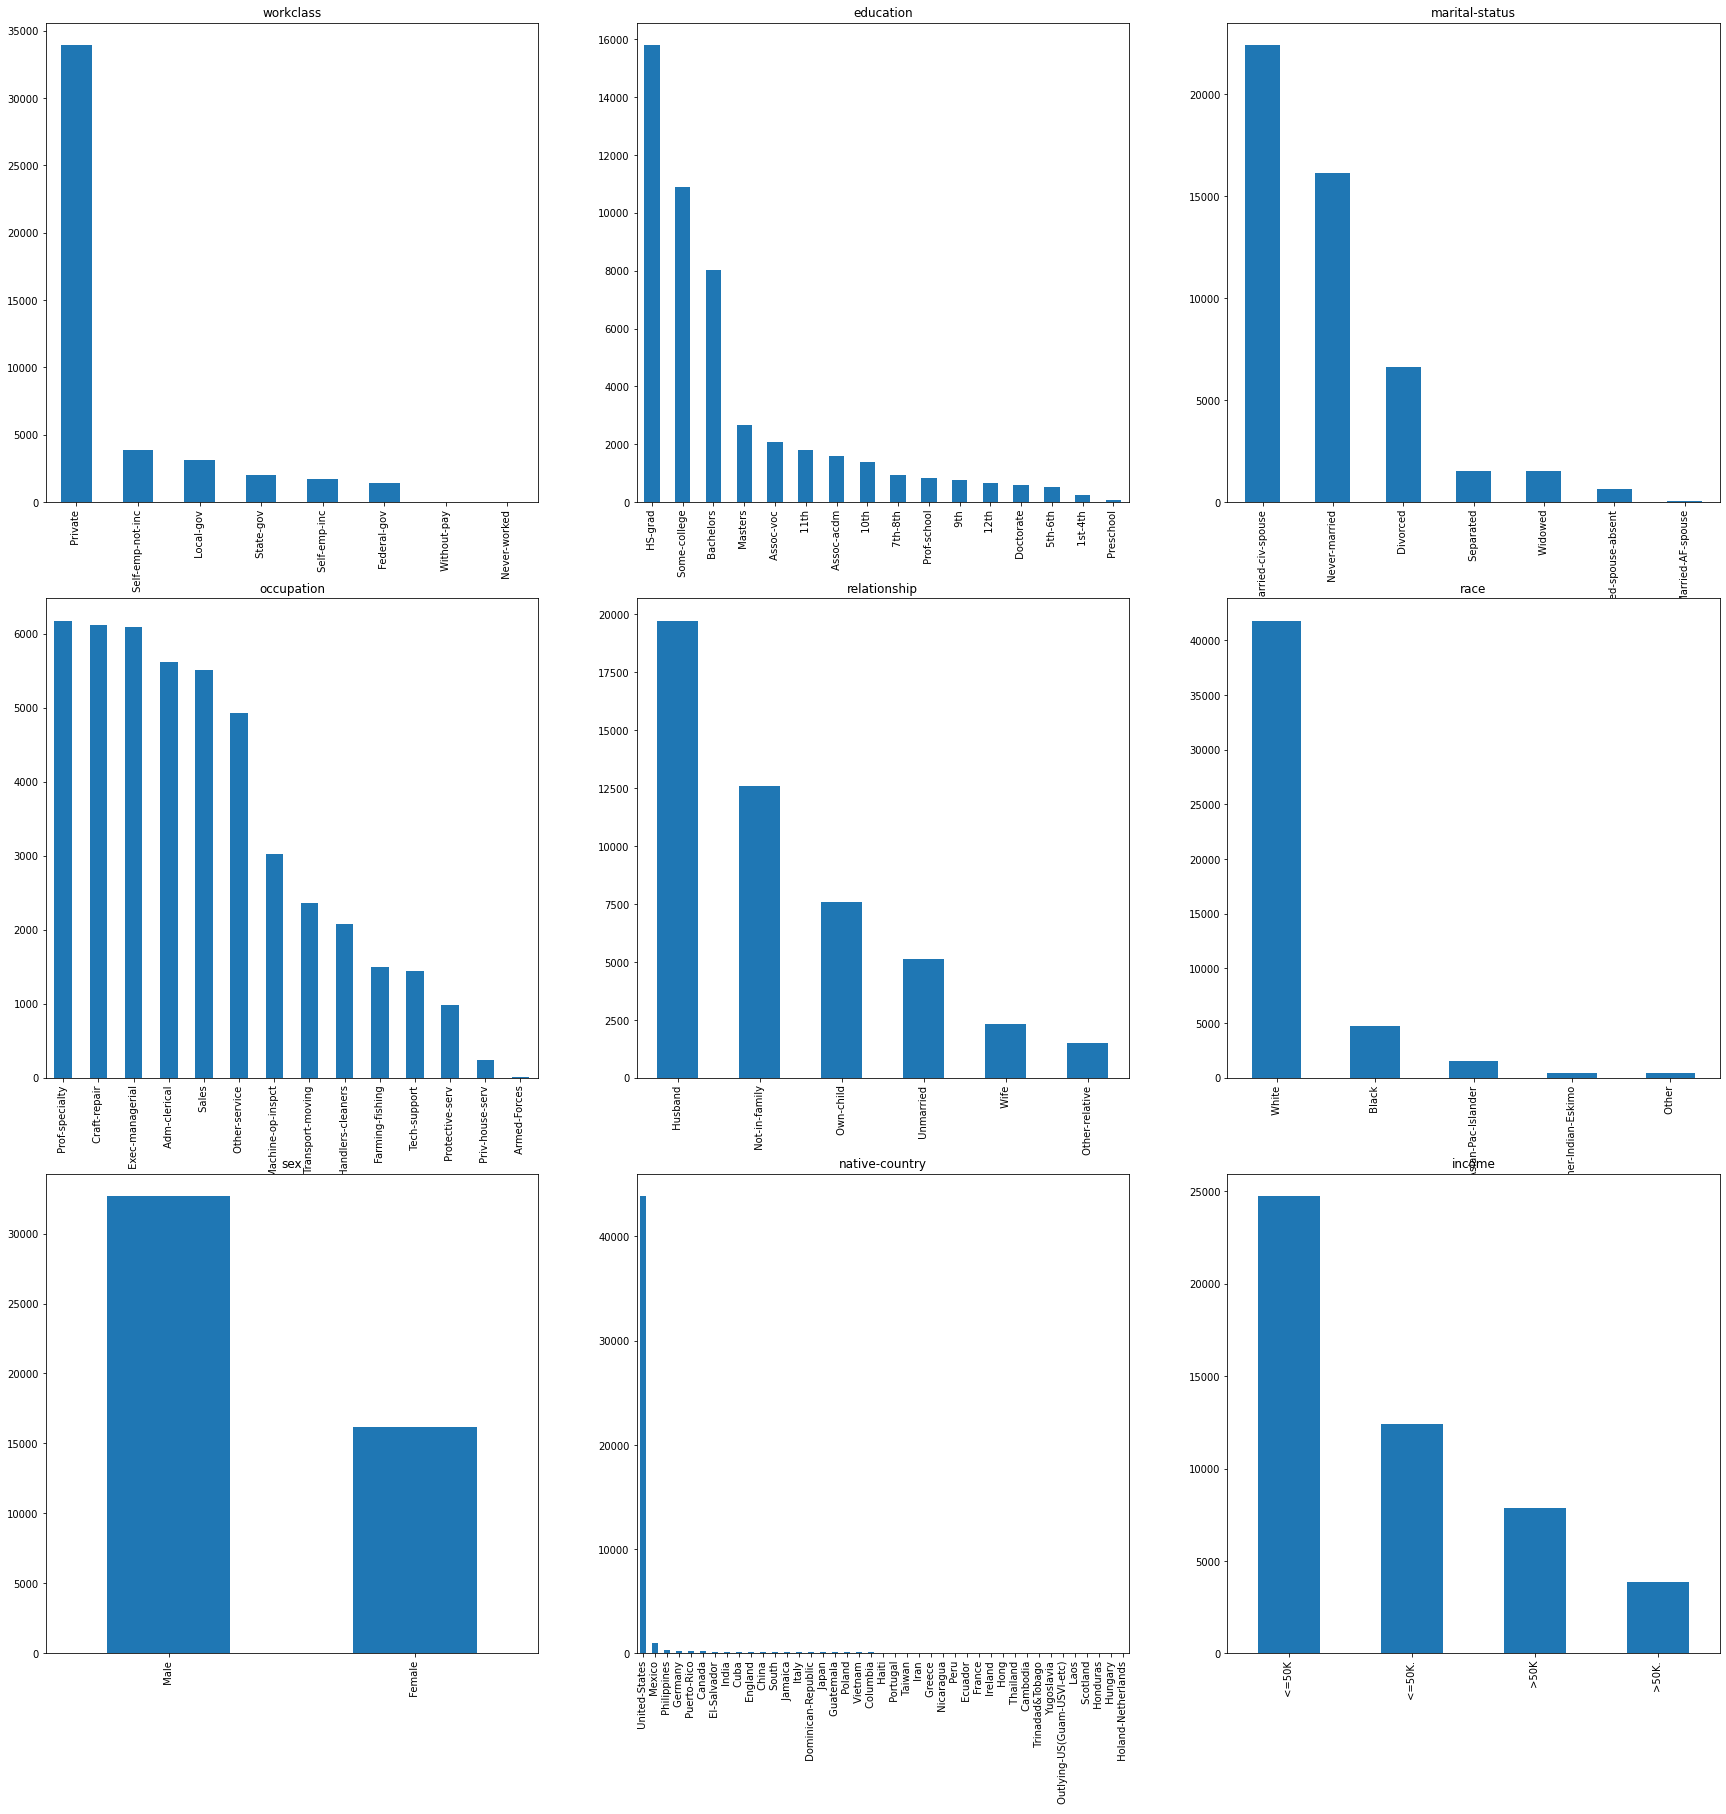

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt


# selecting categorical features
not_num = eda_data[['workclass','education','marital-status','occupation',
                      'relationship','race','sex','native-country','income']]

# ploting categorial features
ncols = 3
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*nrows, 10*ncols))
for column, (i, j) in zip(list(not_num.columns), ((i,j) for i in range(nrows) for j in range(ncols))):
    not_num[column].value_counts().plot(kind="bar", ax=axes[i,j])
    axes[i,j].set_title(column)

It is also possible to see that there is more than one category (' >50K',' <=50K') in the **income** feature. That happens because in the test dataset the category string ends with a dot (' >50K.',' <=50K.'). Therefore it is necessary to normalize the income feature replacing the dot on the test dataset.

3. **Numerical Features**: to analyze the numerical data, we will map the **income** categorical feature to a new boolean feature called **50K_plus**, which is equal to 1 when income is higher than 50 thousand per year, else equals 0. The correlation matrix heatmap below show how the numerical features are correlated with the label **50K_plus**: the numerical features indeed shows some correlation with the label, but the **fnlwgt** label shows no correlation, indicating that this feature could be ignored.

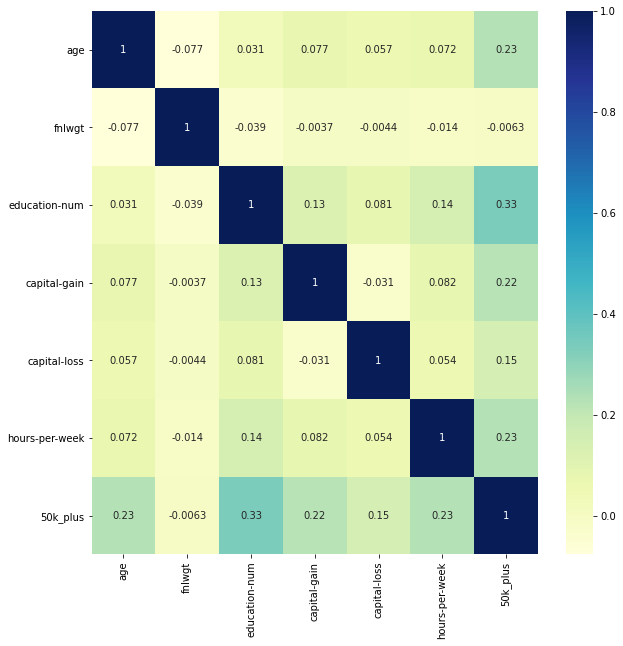

In [49]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

# Select numerical features
num = eda_data[['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week','50k_plus']]

# Normalizing the income feature (remove dots and spaces)
eda_data['50k_plus'] = eda_data['income'].str.replace('.','')
eda_data['50k_plus'] = eda_data['income'].str.replace(' ','')

# Mapping classes to 0 and 1
num = num.replace(to_replace=['<=50K', '>50K',], value=[0,1])

# Plot correlation matrix
corrMatrix = pd.DataFrame(np.corrcoef(num.values, rowvar=False), columns=num.columns, index=num.columns)
fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(corrMatrix,ax=ax, annot=True, cmap="YlGnBu")
plt.yticks(rotation=0) 
plt.show()

4. The estimated probability of the dataset for the income feature is:
    
    - **'>50K'**: 23.93%
    - **'<=50K'**: 76.07%
    
Hence the baseline accuracy for any model trained on this dataset is 76.07%, what could be acchieved by guessing all possible inputs as **<=50K**.

/home/user01/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-104-9a5612b55814>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  eda_data['income'] = eda_data['income'].str.replace('.','')


<AxesSubplot:ylabel='None'>

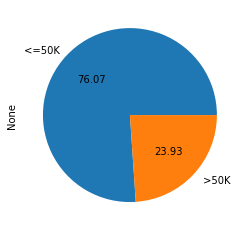

In [104]:
eda_data.groupby('income').size().plot(kind='pie', autopct='%.2f', figsize=(4,4))

# 3. Data Engineering 

In this section the raw Adult dataset will be processed in order to enalble supervised learning. 

## 3.1. Handling missing data

As noted on section **2.1**, 7.41% of the dataset rows have missing data, which occurs only on three categorical features: **workclass**, **occupation**, **native-country**. Basically, we have two options:

1. Remove every row with missing data on at least one column, corresponding to less 7.41% of data in our dataset.
2. Treat the missing data as a new **UNKNOWN** class, in order to keep the whole dataset.

Here we will choose the option **2**. The main reason for this particular decision is to use the biggest dataset possible.



In [7]:
def handle_missing_data(df):
    return df.fillna('UNKNOWN')

no_missing_data = handle_missing_data(pd.concat([train_data, test_data]))

## 3.2. Cleaning the data

As observed with the EDA, the income feature need to be normalized and mapped to a numerical feature (0 or 1). Here we will create a new numerical feature named **50K_plus**.

In [8]:
def clean_data(df):

    # Normalizing the income feature (remove dots and spaces)
    df['50K_plus'] = df['income'].str.replace('.','')
    df['50K_plus'] = df['50K_plus'].str.replace(' ','')

    # Mapping classes to 0 and 1
    df['50K_plus'] = df['50K_plus'].replace(to_replace=['<=50K', '>50K',], value=[0,1])
    
    # Select the interest features to form our clean dataset
    return df[['age', 'workclass', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', '50K_plus']]

cleaned_data = clean_data(no_missing_data)

<ipython-input-8-9a51edd465c6>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['50K_plus'] = df['income'].str.replace('.','')


## 3.4. Feature Engineering

## 3.4.1 Dealing with categorical data

There are many ways to deal with the categorical data. The most canonical and simple method is the **one-hot-encoding**, which is equivalent to create a new column for each class of every categorical feature and map them to zeros and ones. This method leads to a very wide dataset, with many features that might not be meaningful for our purpose of prediciting the **50K_pluss** class. 

The **one-hot-encoding** will be done with the **pandas.get_dummies()** function from the Pandas library. The bar plot below shows the correlation value for each one-hot-encoded feature. 

<AxesSubplot:>

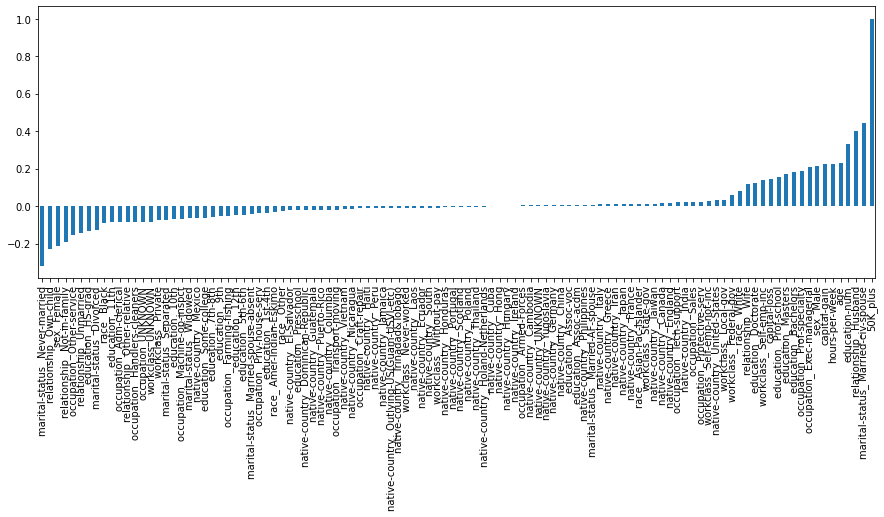

In [9]:
one_hot_encoded = pd.get_dummies(cleaned_data)
feature_corr = one_hot_encoded.corr().loc[:,'50K_plus'].sort_values(ascending=True)
feature_corr.plot(kind='bar', figsize=(15,5))

To avoid unecessary features, we will select only the dummie features above the median when sorted by the absolute value of its correlation with the target variable. We will also remove the dummie features that have the **UNKNOWN** class, as they would not have practical meaning. At the end, we keep 51 features out of a total of 107. 

In [12]:


def feature_engineering(df):
    
    # One hot encode data
    one_hot_encoded = pd.get_dummies(df)
    feature_corr = one_hot_encoded.corr().loc[:,'50K_plus'].sort_values(ascending=True)
    
    # Select features with correlation above the median
    features = feature_corr[feature_corr.abs() >= np.quantile(feature_corr.abs().values, 0.5)]
    feature_list = list(features.index)

    # Remove UNKNOWN classes out of the selected features
    feature_list = [ x for x in feature_list if "UNKNOWN" not in x ]
    
    
    return one_hot_encoded[feature_list]

master_dataset = feature_engineering(cleaned_data)

## 3.5. Data Split

Finally, after preparing the raw data, we can split the dataset into train and test sets, in which a model for predicting if someone's yearly income is higher than 50 thousand dollars will be trained using supervised learning. We will use 1/3 of the dataset for test and 2/3 for training.

In [13]:
from sklearn.model_selection import train_test_split

def split_data(master_dataset):
    
    X = master_dataset.drop('50K_plus', axis=1)
    y = master_dataset['50K_plus']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.33, 
        random_state=5024,
        shuffle=True
    )
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(master_dataset)

/home/user01/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 4. Model Fitting

## 4.1. Fitting the KNN Classifier

In this section we will train a KNN Classifier with K=3. The hyperparameters will be chosen using cross validation and Grid Search.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Defining hyperparamters space
k_range = list(range(1,35))
weights = ['uniform', 'distance']
p_range = list(range(1,3))
param = dict(n_neighbors=k_range, p=p_range)

knn = KNeighborsClassifier(n_neighbors=3)

# Run Grid Search with cross validation
grid = GridSearchCV(knn, param, cv=10, scoring='accuracy', n_jobs = -2)
grid.fit(X_train, y_train)
print(grid.best_estimator_)
print(grid.best_score_)

/home/user01/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 